# Statistical Models (FFT, SARIMA and Tbats)

In this notebook, we build statistical models to predict values in our timeserie. The algorithms used in this case are **Fourier Transform**, **SARIMA** and **TBATS**.

--------

### Table of Contents:

[**Read Files**](#Read-Files)


[**Fourier Transform**](#Fourier-Transform)
* [Explore Data using FFT](#Explore-Data-using-FFT)
* [Train Test Split](#Train-Test-Split)
* [Build the FT Model](#Build-the-FT-Model)
* [Evaluate FT Model](#Evaluate-FT-Model)


[**SARIMA**](#SARIMA)
* [Build the SARIMA Model](#Build-the-SARIMA-Model)
* [Evaluate the SARIMA Model](#Evaluate-the-SARIMA-Model)

[**TBATS**](#TBATS)
* [Build the TBATS Model](#Build-the-TBATS-Model)
* [Evaluate the TBATS Model](#Evaluate-the-TBATS-Model)

------------

# Read Files

In [4]:
# if running in google colab
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# if running in google colab
import os
os.chdir('drive/My Drive/final_version/')

In [1]:
# analysis related libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from time import time
%matplotlib inline
sns.set_style('darkgrid')

In [2]:
# build df path
df_path= os.path.join('datasets_transformed','data_resampled_noisy_outliers.csv')
# read csv file into a df
df= pd.read_csv(df_path, parse_dates=True, index_col=0)
# check df
df.head()

,metric
2019-12-07 00:00:00,52.500469
2019-12-07 00:01:00,56.685361
2019-12-07 00:02:00,58.306072
2019-12-07 00:03:00,54.528461
2019-12-07 00:04:00,56.962642


# Fourier Transform

### Explore Data using FFT

In [3]:
# import fourier transform functions
from scipy.fftpack import fft
from scipy.fftpack import fftfreq

In [4]:
# Fourier Transoform of the metric
y=df.metric
yf = fft(y)
xf = fftfreq(len(y)) * len(y)

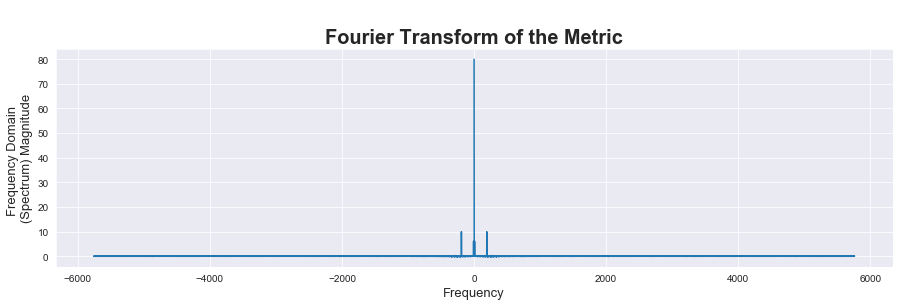

In [5]:
# plot fft
plt.figure(figsize=(15,4))
plt.plot(xf,(yf/5761).real)
plt.xlabel('Frequency', fontsize=13)
plt.ylabel('Frequency Domain \n(Spectrum) Magnitude', fontsize=13)
plt.title('\nFourier Transform of the Metric', fontsize=20, fontweight='bold')
plt.show()

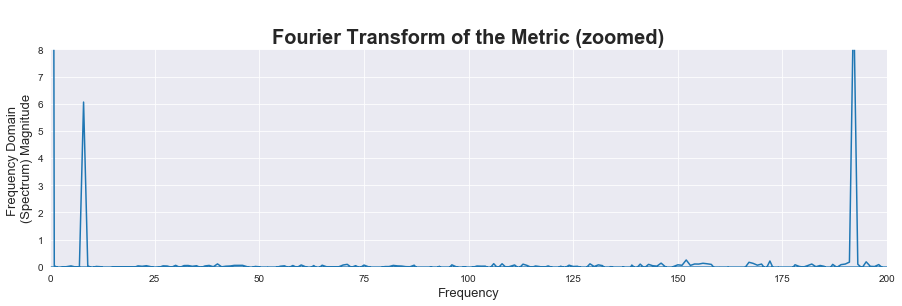

In [6]:
# plot fft
plt.figure(figsize=(15,4))
plt.plot(xf,(yf/5761).real)
plt.xlabel('Frequency', fontsize=13)
plt.ylabel('Frequency Domain \n(Spectrum) Magnitude', fontsize=13)
plt.xlim(0,200)
plt.ylim(0,8)
plt.title('\nFourier Transform of the Metric (zoomed)', fontsize=20, fontweight='bold')
plt.show()

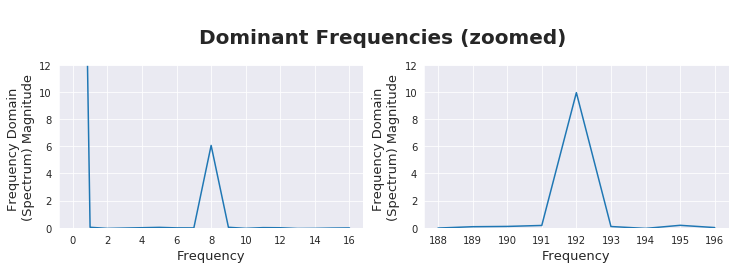

In [7]:
# Plot dominant frequencies side by side
plt.figure(figsize=(12,3))
plt.suptitle('\nDominant Frequencies (zoomed)', y=1.15, fontsize=20, fontweight='bold')
# first plot for first freq
plt.subplot(121)
plt.plot((yf/5761).real[0:17])
plt.xlabel('Frequency', fontsize=13)
plt.ylabel('Frequency Domain \n(Spectrum) Magnitude', fontsize=13)
plt.ylim(0,12)
# second plot for second frew
plt.subplot(122)
plt.plot(range(188,197),(yf/5761).real[188:197])
plt.xlabel('Frequency', fontsize=13)
plt.ylabel('Frequency Domain \n(Spectrum) Magnitude', fontsize=13)
plt.ylim(0,12)
plt.show()

We can observe two seasonal behaviors in the signal. The first seasonality occurs 8 times in the whole recorded duration (8 cycles) and the second seasonality occurs 192 times in the whole recorded duration (192 cycles). 

**Period:**

* T1: 1 day per cycle
* T2: 1 hour per cycle


$T(1) = \frac{Whole Recorded Time}{First Peak}$

$T(2) = \frac{Whole Recorded Time}{Second Peak}$



**Frequency:**

* Freq1 : 1 cycle every 1 Day (8 cycles in the whole time)
* Freq2 : 1 cycle every 1 Hour (192 cycles in the whole time)



In [8]:
## Claculate Periods

# (8days*24hours*60minutes)/(8totalCycles)
T1= (8*24*60)/8
# (8days*24hours*60minutes)/(192totalCycles)
T2= (8*24*60)/192

print(f'\nT1:   {int(T1)} min/cycle  or  1 day/cycle')
print(f'T2:   {int(T2)} min/cycle    or  1 hour/cycle\n')


T1:   1440 min/cycle  or  1 day/cycle
T2:   60 min/cycle    or  1 hour/cycle



### Train Test Split

We specify 7 days for training and one day for testing data.

In [9]:
# train dataset (7 days)
train_df= df.iloc[:7*int(len(df)/8)]
# test dataset (1 day)
test_df= df.iloc[7*int(len(df)/8):]

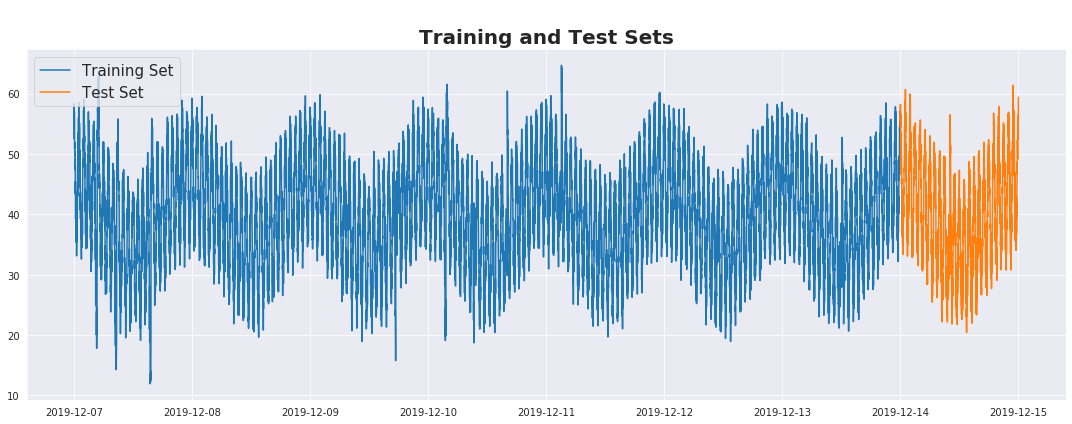

In [10]:
# plot data with outliers
plt.figure(figsize=(15,6))
plt.plot(train_df, label='Training Set')
plt.plot(test_df, label='Test Set')
plt.title('\nTraining and Test Sets', fontsize=20, fontweight='bold')
plt.legend(loc=2 ,prop={'size': 15})
plt.tight_layout()

### Build the FT Model

In [11]:
# create a function that takes a timeseries (signal data)
# specifies the dominant frequencies using fast fourier transform
# makes prediction based on this frequencies

def fourier_transform_prediction(series, n_predicts, plot=False):
    
    """
    This function uses discrete Fourier Transform to predict 
    periodic data.

    Parameters
    ----------
    
    series : pandas dataseries, containing a metric and timestamp index
    
    n_predicts : int, number of values to be predicted with the
                 same time interval as given in series
                 
    plot : bool, if True it plots the predictions

    Returns
    ----------
    
    preds : pandas dataframe, dataframe containing previous data and predictions

    """
    # metric values
    x=series.values
    # number of available values
    n = x.size

    # discrete Fourier transform 
    x_freqdom = np.fft.fft(x)
    # discrete Fourier Transform sample frequencies
    f = np.fft.fftfreq(n)      
    
    # store fft and frequency values in a dtaframe
    fft_df= pd.DataFrame(x_freqdom, index=f, columns=['fft'])
    # frequency spectrum only for positive frequencies
    fft_df['peaks']=fft_df['fft'].apply(np.abs)
    fft_df['amplitude']= fft_df['peaks']/n
    # use zscore to determine dominant freqs
    from scipy.stats import zscore
    fft_df['zscore']=zscore(fft_df['peaks'])
    # filter only dominant frequencies
    dominant = fft_df[fft_df['zscore']>1]

    # creat an empty array to store predicted values in
    t = np.arange(0, n + n_predicts)
    restored_sig = np.zeros(t.size)

    # predicting values
    for i in dominant.index:
        ampli = dominant.amplitude.loc[i]
        phase = np.angle(dominant.fft.loc[i])
        restored_sig += ampli * np.cos(2 * np.pi * i * t + phase)
        
    # time values
    old_dates= series.index
    time_interval= old_dates[-1]-old_dates[-2]
    start_pred_date= old_dates[-1] + time_interval
    pred_dates= pd.date_range(start=start_pred_date, freq=time_interval, periods=n_predicts)
    # total time
    total_time = np.concatenate((old_dates,pred_dates))
    # make a dataframe with predictions
    preds= pd.DataFrame(data=restored_sig, index=total_time, columns=['metric'])
    
    # plot the pred values
    if plot:
        print()
        plt.figure(figsize=(14,7))
        plt.suptitle('Timesries Forecast using FFT', y=1.03, fontsize=20, fontweight='bold')
        plt.subplot(211)
        plt.plot(series, 'b', label = 'Actual Data', alpha=0.5)
        plt.plot(pred_dates, restored_sig[-n_predicts:], 'r', label ='Forecast' , alpha=1)
        plt.legend(loc='upper left',prop={'size': 15})
        plt.subplot(212)
        plt.title('zoomed', fontsize=15)
        plt.plot(series.iloc[-n_predicts:], 'b', label = 'Actual Data', alpha=0.5)
        plt.plot(total_time[-n_predicts:], restored_sig[-n_predicts:], 'r', label ='Forecast' , alpha=1)
        plt.tight_layout()
        plt.show()
        
        

    return preds

### Evaluate FT Model

In [12]:
# make predictions
start=time()
preds= fourier_transform_prediction(train_df.metric, 1441, plot=False)
time_FT=time()-start

In [18]:
# save
preds[7*int(len(preds)/8):].rename(columns={'metric':'FFT'}).to_pickle(os.path.join('comparison','fft_preds.pkl'))

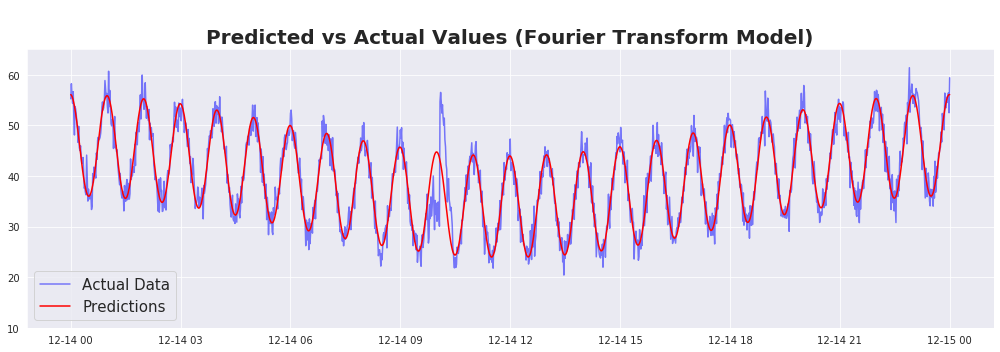

In [13]:
# plot predictions
plt.figure(figsize=(14,5))
plt.title('\nPredicted vs Actual Values (Fourier Transform Model)',fontsize=20, fontweight='bold')
plt.plot(df[7*int(len(df)/8):], 'b', label = 'Actual Data', alpha=0.5)
plt.plot(preds[7*int(len(preds)/8):], 'r', label = 'Predictions')
plt.legend(prop={'size': 15})
plt.ylim(10,65)
plt.tight_layout()

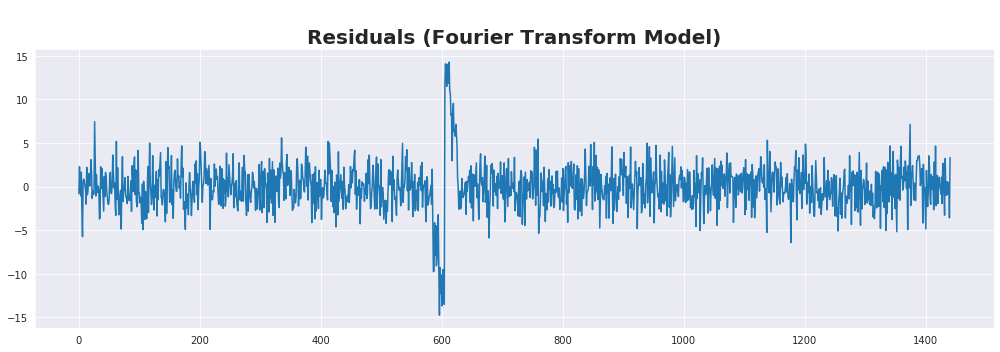

In [14]:
# plot residuals
plt.figure(figsize=(14,5))
plt.title('\nResiduals (Fourier Transform Model)',fontsize=20, fontweight='bold')
plt.plot(test_df.values-preds[-1441:].values)
plt.tight_layout()

In [15]:
# Claculate RMSE
from sklearn.metrics import mean_squared_error
RMSE_FT= np.sqrt(mean_squared_error(test_df.values, preds.iloc[-1441:].values))
print('RMSE Fourier Transform Model: ' ,round(RMSE_FT,4))

RMSE Fourier Transform Model:  2.6214


In [0]:
# save rmse and run time to a dataframe for later comparison between models
comparison= pd.DataFrame(columns=['model','time','rmse'])
comparison= pd.concat([comparison,pd.DataFrame({'model':['Fourier Transform'],
                                                'time':[time_FT],
                                                'rmse':[RMSE_FT]})])

## SARIMA

### How to Configure SARIMA

Configuring a SARIMA requires selecting hyperparameters for both the trend and seasonal elements of the series.

**Trend Elements**:
There are three trend elements that require configuration.

They are the same as the ARIMA model; specifically:

* p: Trend autoregression order.
* d: Trend difference order.
* q: Trend moving average order.


**Seasonal Elements**:
There are four seasonal elements that are not part of ARIMA that must be configured; they are:

* P: Seasonal autoregressive order.
* D: Seasonal difference order.
* Q: Seasonal moving average order.
* m: The number of time steps for a single seasonal period.

### Build the SARIMA Model

In [19]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [0]:
### Grid Search to find the optimum trends

# import itertools
# # Define the p, d and q parameters to take 0 and 1
# p = d = q = range(0, 2)
# # Generate all different combinations of p, q and q triplets
# pdq = list(itertools.product(p, d, q))
# # Generate all different combinations of seasonal p, q and q triplets
# seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
# for param in pdq:
#     for param_seasonal in seasonal_pdq:
#         mod = sm.tsa.statespace.SARIMAX(y,
#                                         order=param,
#                                         seasonal_order=param_seasonal,
#                                         enforce_stationarity=False,
#                                         enforce_invertibility=False)
#         results = mod.fit()
#         print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))

In [20]:
# define model configuration
trend_order = (0, 0, 0)
seasonal_order = (1, 1, 1, 60)
# define model
model = SARIMAX(train_df.values, order=trend_order, seasonal_order=seasonal_order)

In [ ]:
# fit model
start = time()
model_fit = model.fit()
time_sarima = time()-start

### Evaluate the SARIMA Model

In [0]:
yhat = model_fit.forecast(steps=1441)

In [ ]:
# save
pd.DataFrame(data={'SARIMA_preds':yhat},
             index=test_df.index).to_pickle(os.path.join('comparison','SARIMA_preds.pkl'))

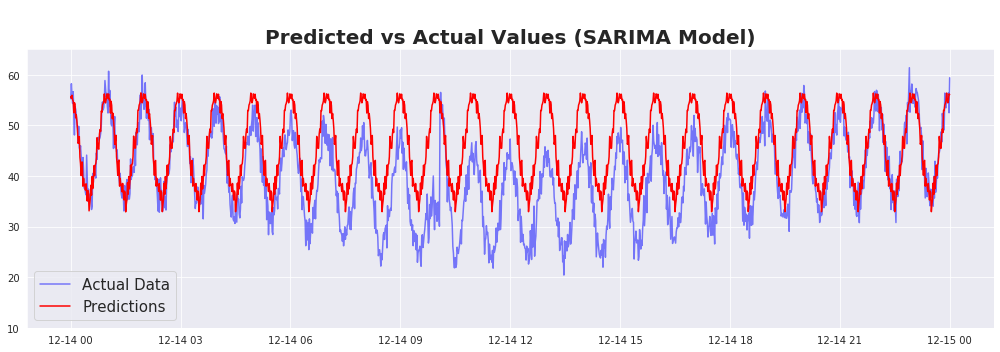

In [29]:
# plot predictions
plt.figure(figsize=(14,5))
plt.title('\nPredicted vs Actual Values (SARIMA Model)',fontsize=20, fontweight='bold')
plt.plot(test_df, 'b', label = 'Actual Data', alpha=0.5)
plt.plot(test_df.index, yhat, 'r', label = 'Predictions')
plt.legend(prop={'size': 15})
plt.ylim(10,65)
plt.tight_layout()

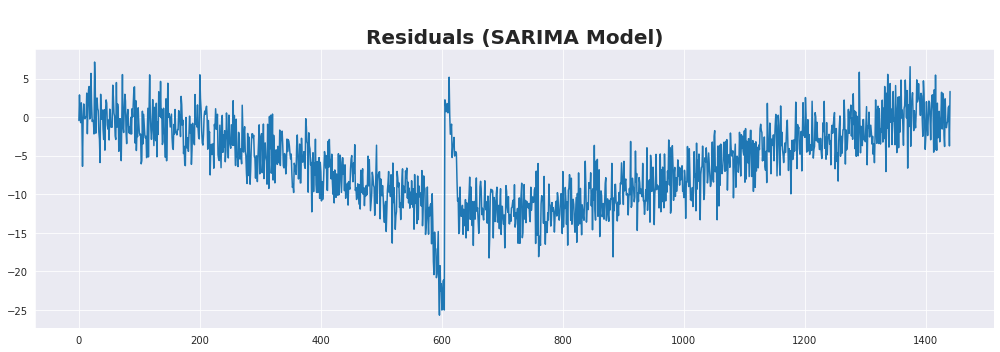

In [35]:
# plot residuals
plt.figure(figsize=(14,5))
plt.title('\nResiduals (SARIMA Model)',fontsize=20, fontweight='bold')
plt.plot(test_df.values.flatten()-yhat)
plt.tight_layout()

In [36]:
# Claculate RMSE
from sklearn.metrics import mean_squared_error
RMSE_SARIMA= np.sqrt(mean_squared_error(test_df.values, yhat))
print('RMSE SARIMA: ' ,round(RMSE_SARIMA,4))

RMSE SARIMA:  7.8696


In [0]:
# save rmse and run time
comparison= pd.concat([comparison,pd.DataFrame({'model':['SARIMA'],
                                                'time':[time_sarima],
                                                'rmse':[RMSE_SARIMA]})])

# TBATS

### Build the TBATS Model

In [0]:
from tbats import TBATS

In [0]:
estimator = TBATS(seasonal_periods=(60, 1440))
start = time()
model = estimator.fit(train_df)
time_tbats = time()-start

### Evaluate the TBATS Model

In [0]:
y_forecast = model.forecast(steps=1441)

In [0]:
pd.DataFrame(data={'tbats_forecast':y_forecast},index=test_df.index).to_pickle('comparison/tbats.pkl')

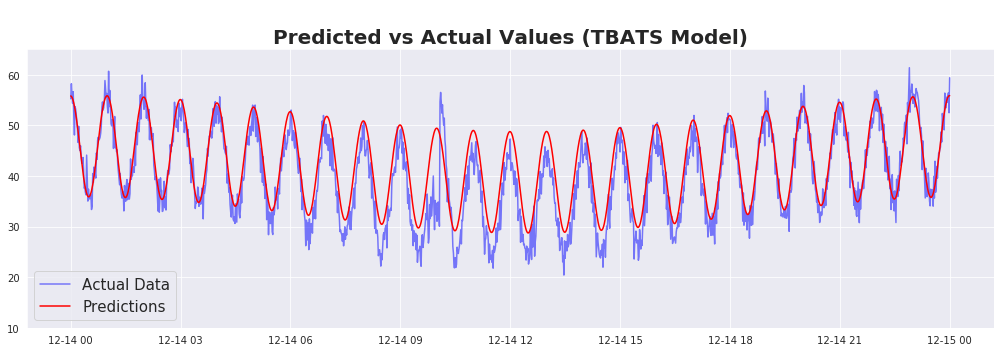

In [58]:
# plot predictions
plt.figure(figsize=(14,5))
plt.title('\nPredicted vs Actual Values (TBATS Model)',fontsize=20, fontweight='bold')
plt.plot(test_df, 'b', label = 'Actual Data', alpha=0.5)
plt.plot(test_df.index, y_forecast, 'r', label = 'Predictions')
plt.legend(prop={'size': 15})
plt.ylim(10,65)
plt.tight_layout()

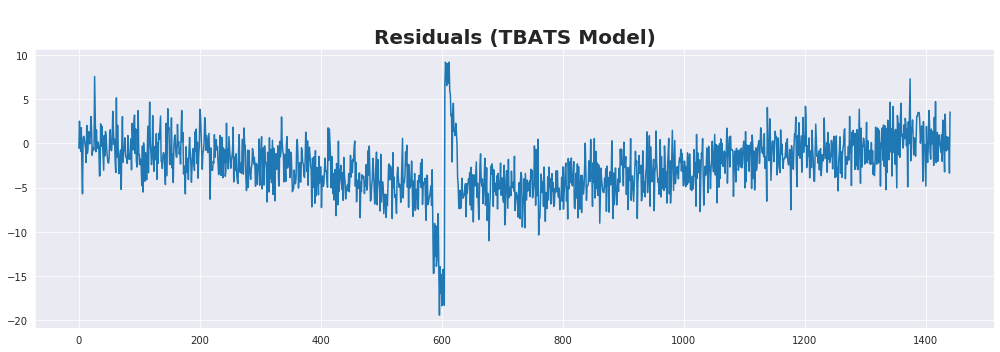

In [59]:
# plot residuals
plt.figure(figsize=(14,5))
plt.title('\nResiduals (TBATS Model)',fontsize=20, fontweight='bold')
plt.plot(test_df.values.flatten()-y_forecast)
plt.tight_layout()

In [60]:
## RMSE
RMSE_TBATS= np.sqrt(mean_squared_error(test_df.values, y_forecast))
print('RMSE TBATS: ' ,round(RMSE_TBATS,4))

RMSE TBATS:  4.0438


In [0]:
# save rmse and run time
comparison= pd.concat([comparison,pd.DataFrame({'model':['TBATS'],
                                                'time':[time_tbats],
                                                'rmse':[RMSE_TBATS]})])

In [62]:
comparison

,model,time,rmse
0,Fourier Transform,0.034534,2.621366
0,SARIMA,149.854580,7.869614
0,TBATS,2420.605045,4.043840


In [0]:
# comparison path
comp_path= os.path.join('comparison','comparison.pkl')
comp_path_csv= os.path.join('comparison','comparison.csv')
comparison.to_pickle(comp_path)
comparison.to_csv(comp_path_csv, index=False)